<a href="https://colab.research.google.com/github/thatajml/Student-Performance-Prediction/blob/dataset/cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Dataset loaded successfully!

Dataset Shape: (2000, 17)
First 5 Rows:
   id first_name last_name                                  email  gender  \
0   1       Paul     Casey         paul.casey.1@gslingacademy.com    male   
1   2   Danielle  Sandoval  danielle.sandoval.2@gslingacademy.com  female   
2   3       Tina   Andrews       tina.andrews.3@gslingacademy.com  female   
3   4       Tara     Clark         tara.clark.4@gslingacademy.com  female   
4   5    Anthony    Campos     anthony.campos.5@gslingacademy.com    male   

   part_time_job  absence_days  extracurricular_activities  \
0          False             3                       False   
1          False             2                       False   
2          False             9                        True   
3          False             5                       False

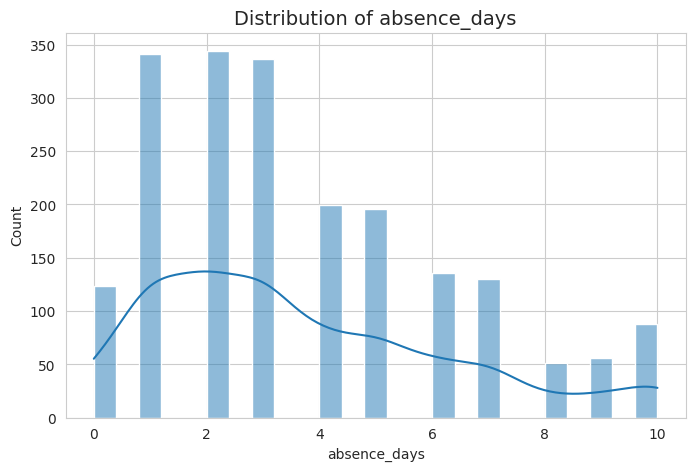

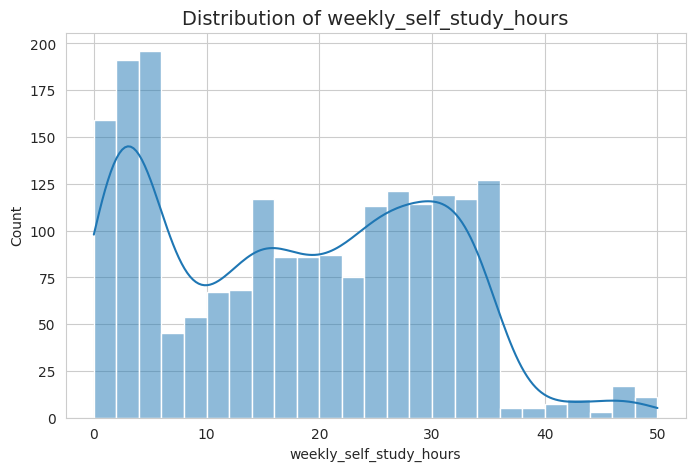

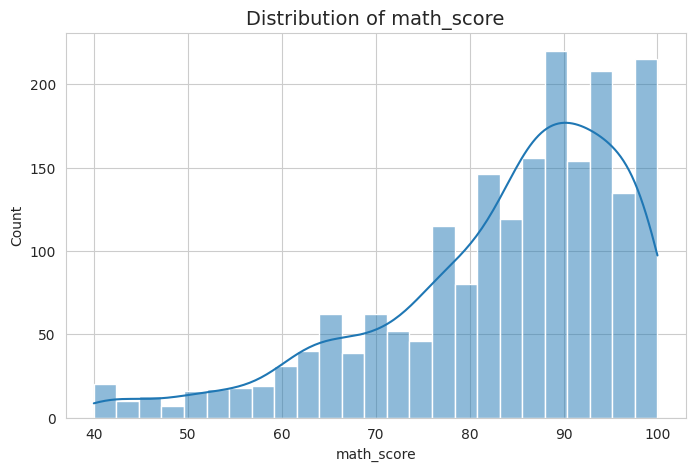

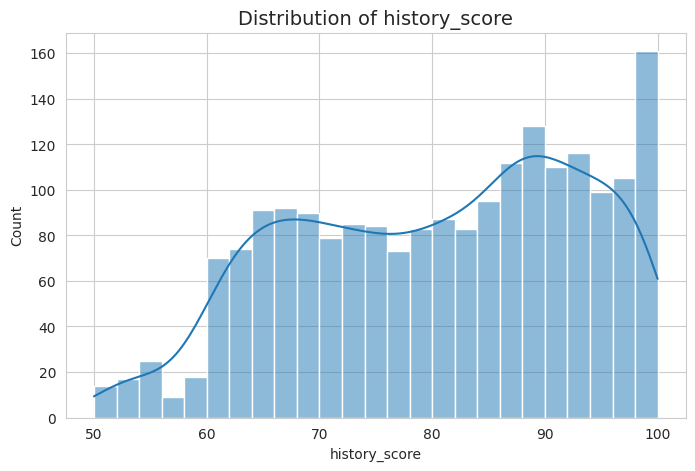

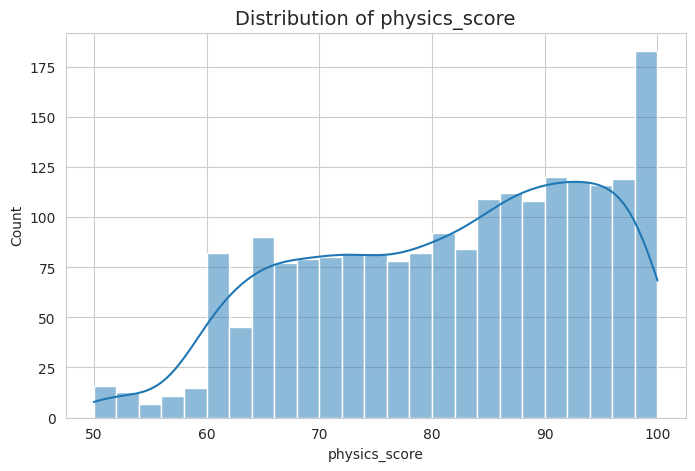

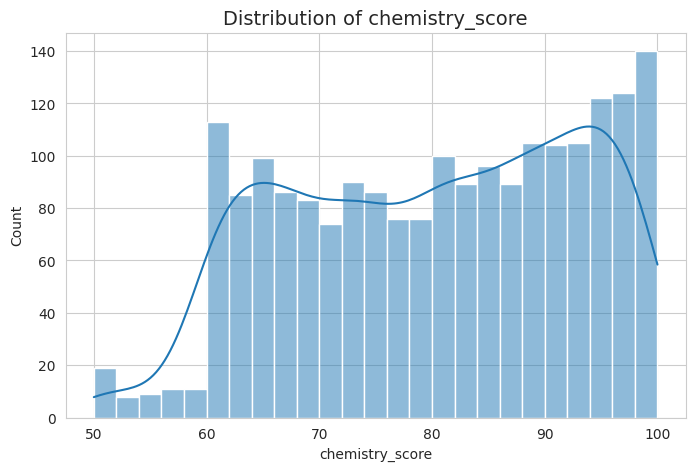

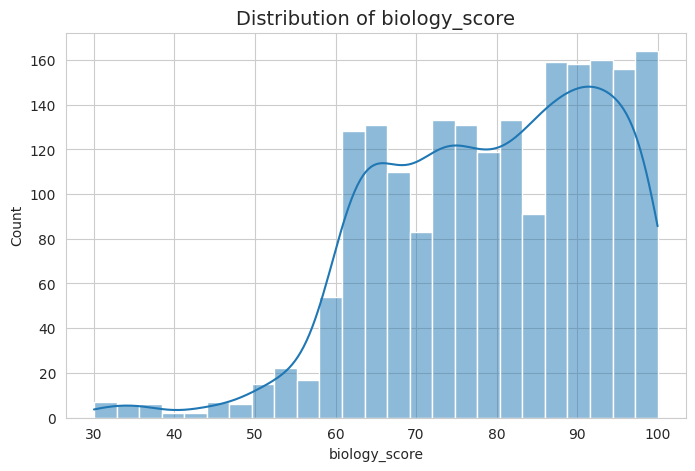

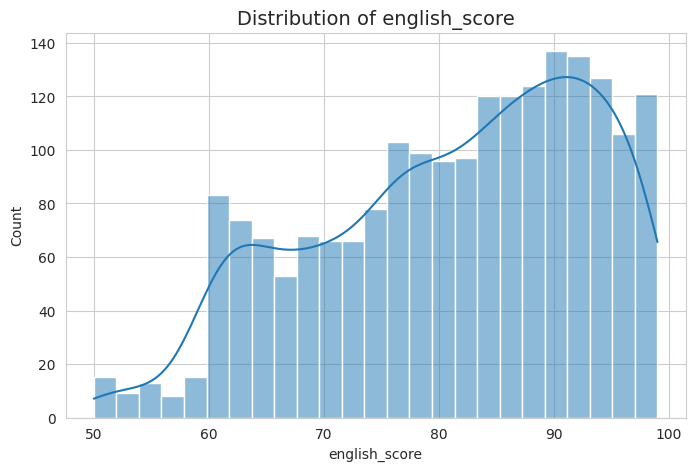

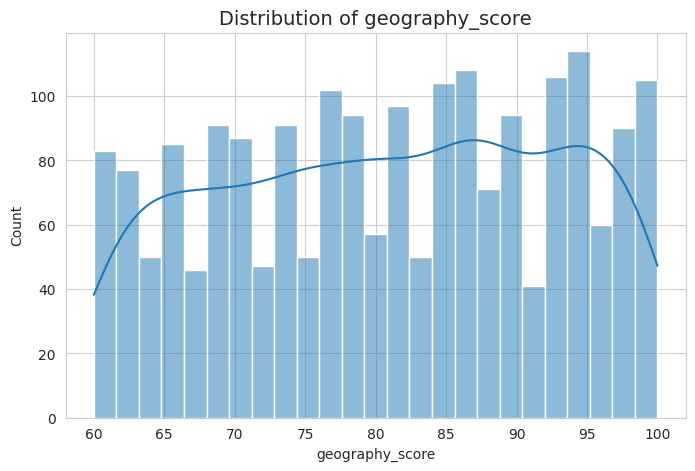

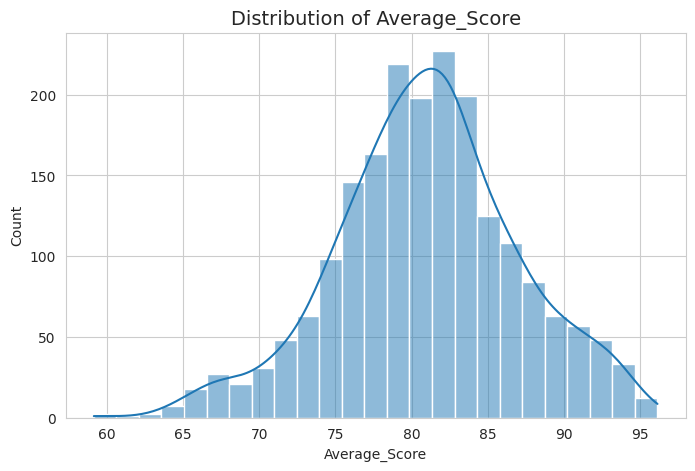

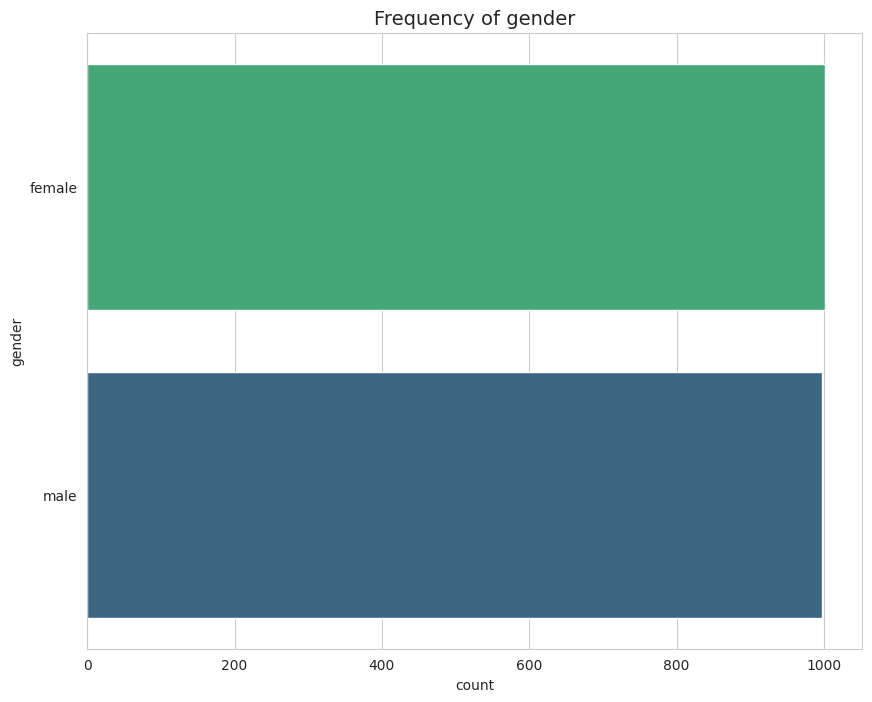

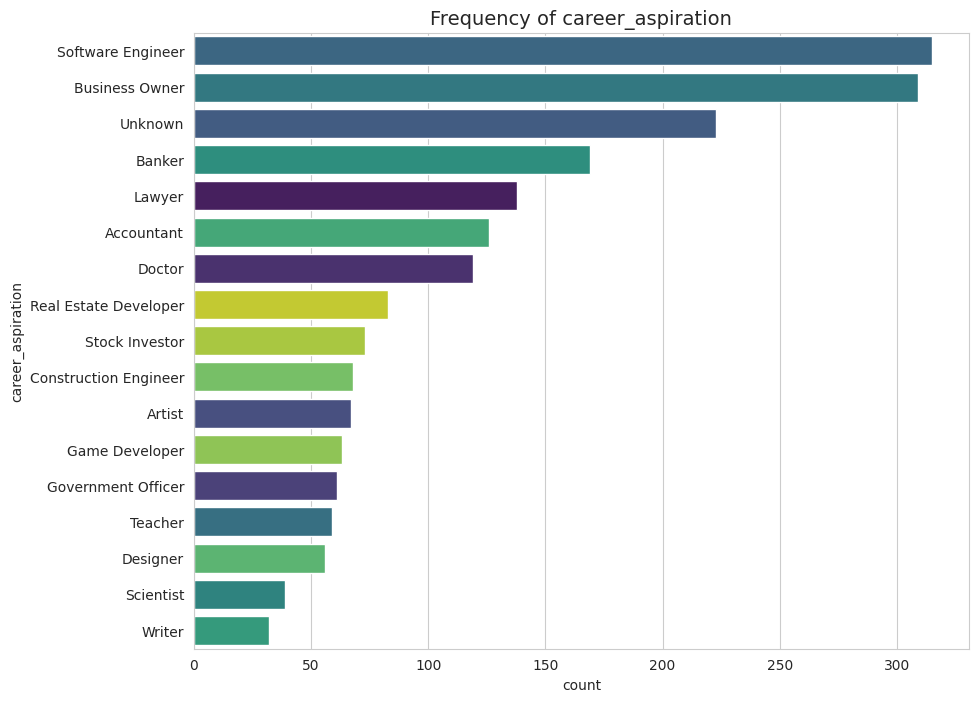


--- Correlation Matrix ---


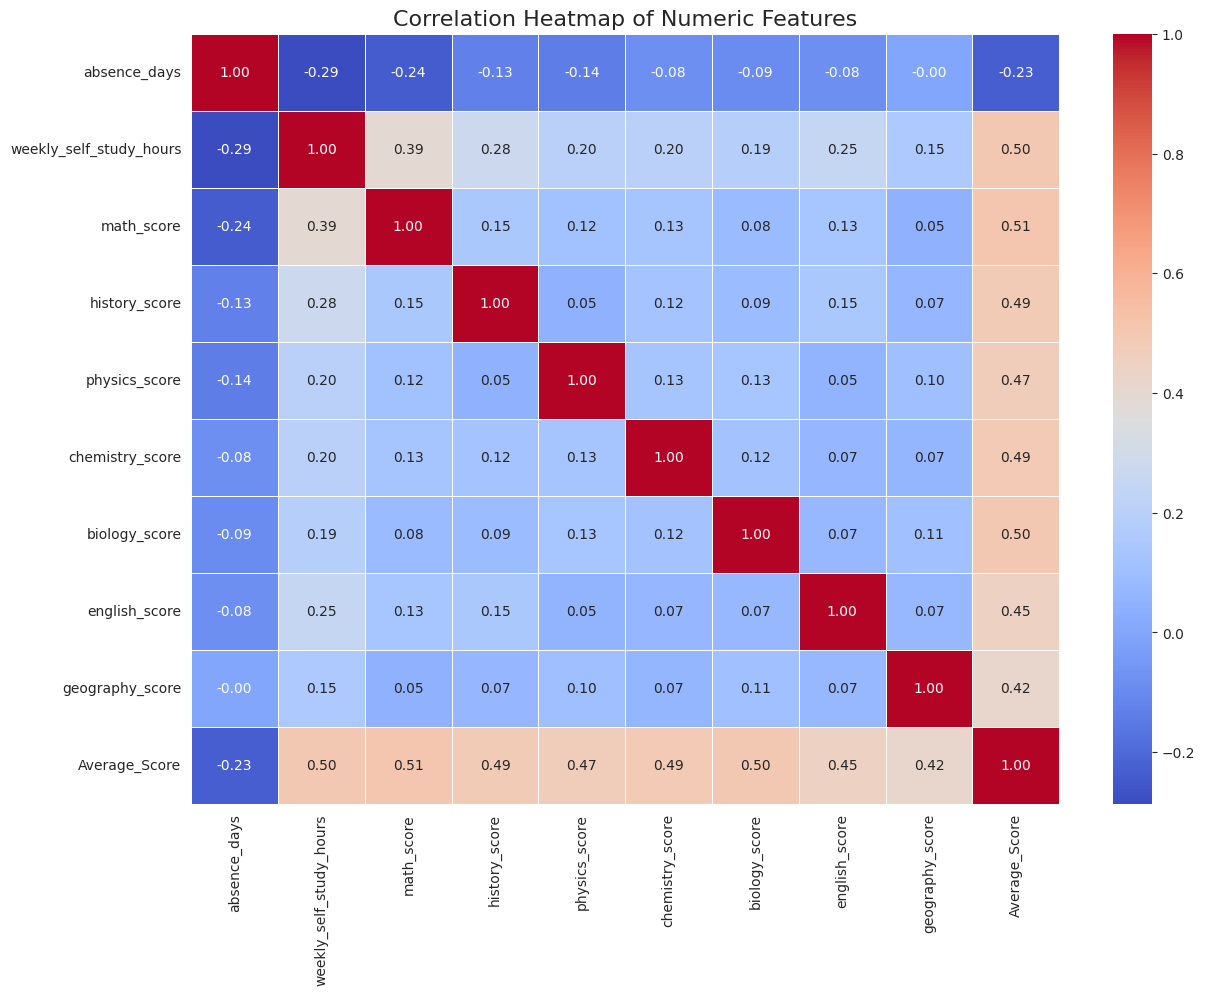


--- SCRIPT FINISHED ---


In [13]:
# ====================================================================
# CORE SCRIPT: STUDENT PERFORMANCE PREDICTION (PREPROCESSING & EDA)
# ====================================================================

# ---------------------------
# 1. IMPORT LIBRARIES
# ---------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

# Import standard preprocessing tools from scikit-learn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


# ---------------------------
# 2. MOUNT DRIVE & LOAD DATA
# ---------------------------
print("Connecting to Google Drive...")
drive.mount('/content/drive')

# --- IMPORTANT: Change this path to where your file is located ---
file_path = "/content/drive/My Drive/ML Miniproject Dataset/student-scores.csv"

try:
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully!")
    print("\nDataset Shape:", df.shape)
    print("First 5 Rows:")
    print(df.head())
except FileNotFoundError:
    print(f"❌ ERROR: File not found at {file_path}. Please check the file path and try again.")
    exit() # Stop the script if the file isn't found


# ---------------------------
# 3. FEATURE ENGINEERING (TARGET VARIABLE CREATION)
# ---------------------------
# --- Create a target variable (Average Score) ---
# Identify the score columns to calculate the average for prediction
score_columns = ['math_score', 'history_score', 'physics_score', 'chemistry_score', 'biology_score', 'english_score', 'geography_score']

# Calculate the average and create the new column
df['Average_Score'] = df[score_columns].mean(axis=1)

print("\n✅ 'Average_Score' column created as the target variable.")


# ---------------------------
# 4. STANDARD PREPROCESSING
# ---------------------------
print("\nStarting data preprocessing...")

# Identify numeric and categorical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# --- Define Preprocessing Pipelines ---
# Impute missing numeric values with the mean, then scale.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Impute missing categorical values with the most frequent value, then encode.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Create the master preprocessor object to apply steps to correct columns
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# Apply the transformations
df_cleaned_np = preprocessor.fit_transform(df)

# Recreate the cleaned DataFrame with proper column names
try:
    cat_encoded_cols = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_cols)
    all_cols = num_cols + list(cat_encoded_cols)
except AttributeError:
    cat_encoded_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(cat_cols)
    all_cols = num_cols + list(cat_encoded_cols)

df_cleaned = pd.DataFrame(df_cleaned_np, columns=all_cols, index=df.index)
print("✅ Preprocessing pipeline complete!")


# ---------------------------
# 5. SAVE OUTPUTS TO DRIVE
# ---------------------------
output_folder_path = "/content/drive/My Drive/ML Miniproject Dataset/"

# Save cleaned data
cleaned_csv_path = "cleaned_student_scores.csv"
df_cleaned.to_csv(cleaned_csv_path, index=False)
print(f"\n✅ Cleaned dataset saved as '{cleaned_csv_path}'")

# Create and save a standard EDA summary
summary = f"""
EDA Summary Report
------------------
Date: {pd.to_datetime('today', utc=True).astimezone('Asia/Kolkata').strftime('%Y-%m-%d %H:%M:%S')}

1.  **Dataset Shape**: Original: {df.shape}, Cleaned: {df_cleaned.shape}.
2.  **Feature Engineering**:
    * Created 'Average_Score' as the target variable.
3.  **Preprocessing Steps**:
    * **Missing Numeric Values**: Imputed with column mean.
    * **Missing Categorical Values**: Imputed with column mode.
    * **Scaling & Encoding**: Numeric features were standardized, and categorical features were OneHotEncoded.
"""
summary_path = "EDA_Summary.txt"
with open(summary_path, "w") as f:
    f.write(summary)
print(f"✅ EDA summary saved as '{summary_path}'")

# Copy outputs to Google Drive
!cp {cleaned_csv_path} "{output_folder_path}"
!cp {summary_path} "{output_folder_path}"
print(f"✅ All outputs successfully copied to your Google Drive!")


# ---------------------------
# 6. VISUALIZATIONS (EDA)
# ---------------------------
print("\nGenerating visualizations...")
sns.set_style("whitegrid")

# --- Univariate Analysis (Understanding each feature) ---
print("\n--- Feature Distributions and Counts ---")
# Histograms for numeric data
for col in num_cols:
    if col != 'id': # Exclude the ID column from plotting
      plt.figure(figsize=(8, 5))
      sns.histplot(df[col], kde=True, bins=25)
      plt.title(f"Distribution of {col}", fontsize=14)
      plt.show()

# Countplots for meaningful categorical data
cols_to_exclude = ['email', 'first_name', 'last_name']
cat_cols_to_plot = [col for col in cat_cols if col not in cols_to_exclude]
for col in cat_cols_to_plot:
    plt.figure(figsize=(10, 8))
    sns.countplot(data=df, y=col, hue=col, palette='viridis', order=df[col].value_counts().index, legend=False)
    plt.title(f"Frequency of {col}", fontsize=14)
    plt.show()


# --- Correlation Heatmap ---
print("\n--- Correlation Matrix ---")
plt.figure(figsize=(14, 10))
# Exclude the 'id' column from the correlation matrix as it is not a predictive feature
sns.heatmap(df[num_cols].drop(columns=['id']).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.show()


print("\n--- SCRIPT FINISHED ---")